<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/25_Neural_Style_Transfer/25_Neural_Style_Transfer_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural style transfer (NST) using PyTorch**

***What is Neural Style Transfer?***

“Imagine painting your photo in Picasso’s style.”

- NST is a DL technique that blends the one image's content with another's style.
- Uses CNNs to separate and recombine content and style from images.


***The Core Idea***

We optimize a new image such that:
- Its content resembles a content image
- Its style matches that of a style image

We define two losses:
- **Content Loss**: Measures what is in the image
- **Style Loss**: Measures how it’s presented

We will use the given images in the task:

***Style Image:***

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/The_Scream.jpg" width="250px" height="300px"/>

***Content Image:***

<img src="https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d" width="250px" height="300px"/>

Importing Packages and Selecting a Device
-----------------------------------------
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)

# **Step 1: Imports and configure modules**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F   # Functional layer API (e.g., mse_loss)
import torch.optim as optim       # Optimization algorithms (SGD, Adam, L-BFGS)
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms  # To convert images to tensors, resize, etc.
import torchvision.models as models          # Pre-trained models
import copy  # Needed to make deep copies of model components
import requests
from io import BytesIO  # Import BytesIO to handle binary data from the image download

# **Step 2: Setup Device**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Step 3: Load and Preprocess Images**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor() # Converts image [0,255] → [0,1] and HWC → CHW
                            ])

def image_loader(pil_img):
    image = Image.open(pil_img)
    image = loader(image).unsqueeze(0)     # Add a fake batch dimension [C x H x W] → [1 x C x H x W]
    return image.to(device, torch.float)   # Send image to device

style_img = image_loader('/content/drive/MyDrive/Colab Notebooks/style_img.jpg')
content_img = image_loader('/content/drive/MyDrive/Colab Notebooks/content_img.jpeg')

assert style_img.size() == content_img.size(), \
    "Style and content images must be of the same size"

# **Step 4: Display Images**

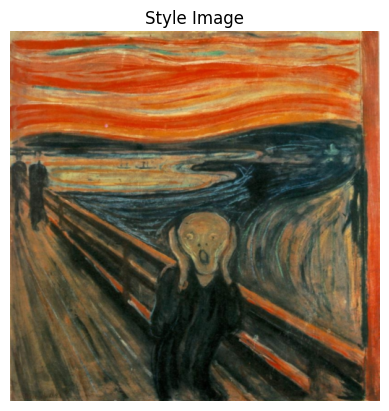

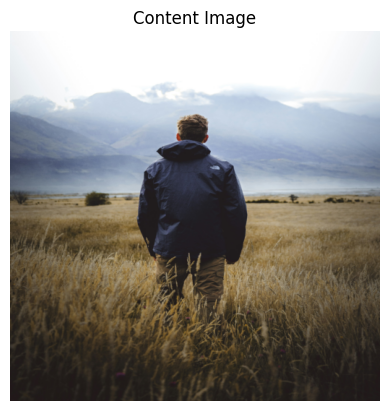

In [5]:
# Utility to display a tensor image (converted to PIL)
def imshow(tensor, title=None):
    image = tensor.detach().cpu().squeeze(0)  # Detach from graph, move to CPU, remove batch
    image = transforms.ToPILImage()(image)    # Convert to PIL for display
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')      # Hide axis for a cleaner view
    plt.show()           # Show the image (auto-updates in notebooks)

# Display the style and content images
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

# **Step 5: Define Content Loss Module**

* **Content loss** checks how much the generated image's content differs from the original content image using feature maps from the network.
* used in the middle of a network to record content loss at certain layers.
* It uses **MSE (Mean Squared Error)** to compare those feature maps.
* The layer saves this loss during the forward pass but lets the image keep flowing through the network unchanged.

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()       # detach() breaks the gradient graph, keeping the target fixed (no updates)

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) #F -> Functional API of PyTorch.nn
        return input

# **Step 6: Define Style Loss Module**

* Measures how well the **textures and patterns** of the style image are captured.
* Uses a **Gram matrix** to represent the style (it compares feature maps' correlations).
* Computes the **difference (MSE)** between the style of the generated image and the original style image.

# **What is a Gram Matrix?**
- It captures the image's style (texture & patterns) by measuring the correlations b/w feature maps at a particular layer of a CNN.

If:

- Feature maps are like filters that detect visual features (like edges, patterns, textures),

- Then the correlation between these filters captures how they interact, which is what "style" is all about.

In [7]:
# Compute Gram Matrix
def gram_matrix(input):
    a, b, c, d = input.size()         # a=batch, b=features, c=height, d=width
    # Flattens feature maps into 1D vectors, reshaping input to `[b, c*d]` where rows are feature maps & columns are pixel locations.
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())  # G = F * F^T (dot product)
    return G.div(a * b * c * d)        # Normalize

In [8]:
# Define StyleLoss Module
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()  # detach() prevents gradients from being calculated for this tensor (don’t wanna update style)

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# **Step 7: Load Pretrained VGG Network**

In [9]:
# Loads VGG19 without classification head
cnn = models.vgg19(pretrained=True).features.to(device).eval()  # Loads pretrained VGG19 model (only convolutional layers)

# Normalization Module
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # reshaping the mean & std to be shape [C, 1, 1] so they can be broadcasted over image tensors of shape [B, C, H, W]:
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std   # normalize img

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 190MB/s]


# **Step 8: Rebuild Network with Loss Layers**

In [10]:
# desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [11]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img,
                               content_img,content_layers=content_layers_default, style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)  # Copy original network
  # Create new Sequential model
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses, style_losses = [], []
  model = nn.Sequential(normalization)
  i = 0
  for layer in cnn.children():
      if isinstance(layer, nn.Conv2d):
          i += 1
          name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)
      else:
          raise RuntimeError('Unrecognized layer:', layer.__class__.__name__)

      model.add_module(name, layer)
      if name in content_layers:
          # add content loss
          target = model(content_img).detach()
          content_loss = ContentLoss(target)
          model.add_module("content_loss_{}".format(i), content_loss)
          content_losses.append(content_loss)

      if name in style_layers:
          # add style loss
          target_feature = model(style_img).detach()
          style_loss = StyleLoss(target_feature)
          model.add_module("style_loss_{}".format(i), style_loss)
          style_losses.append(style_loss)

  # now we trim off the layers after the last content and style losses
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]
  return model, style_losses, content_losses

# **Step 9: Choose Input Image**

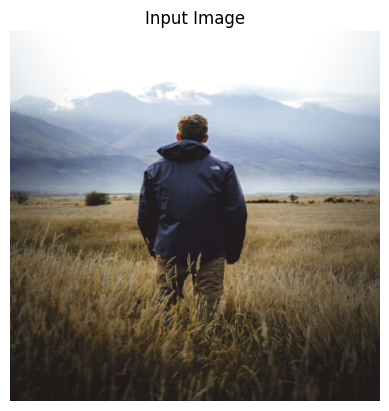

In [12]:
# Next, we select the input image. You can use a copy of the content image or white noise.
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

# **Step 10: Create Optimizer**

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# **Step 11: Run Style Transfer**

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()   # clear out the gradients of all parameters that the optimizer is tracking
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img

# **Step 12: Display & Save Final Output**

Building the style transfer model..


/tmp/ipython-input-9-3118880160.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipython-input-9-3118880160.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 103.881660 Content Loss: 10.248197

run [100]:
Style Loss : 40.540497 Content Loss: 10.522586

run [150]:
Style Loss : 20.029573 Content Loss: 9.769292

run [200]:
Style Loss : 11.217735 Content Loss: 8.864820

run [250]:
Style Loss : 6.169438 Content Loss: 8.220551

run [300]:
Style Loss : 3.949299 Content Loss: 7.706753

run [350]:
Style Loss : 2.486679 Content Loss: 7.379468

run [400]:
Style Loss : 1.515903 Content Loss: 7.119651

run [450]:
Style Loss : 1.021820 Content Loss: 6.881312

run [500]:
Style Loss : 0.753798 Content Loss: 6.682793

run [550]:
Style Loss : 0.617895 Content Loss: 6.518321

run [600]:
Style Loss : 0.547965 Content Loss: 6.390041

run [650]:
Style Loss : 0.507717 Content Loss: 6.290327

run [700]:
Style Loss : 0.484311 Content Loss: 6.211531

run [750]:
Style Loss : 0.484276 Content Loss: 6.150219

run [800]:
Style Loss : 0.455829 Content Loss: 6.107884

run [850]:
Style Loss : 0.445574 Content Loss: 6.075943

run [900]:
S

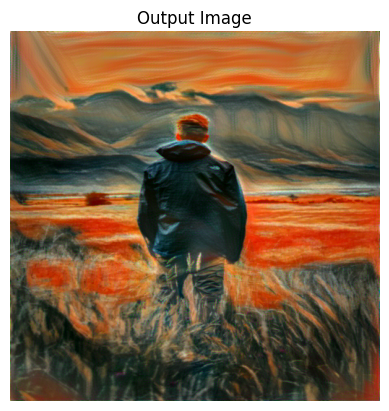

<Figure size 640x480 with 0 Axes>

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

file_name = "stylized-image.png"
plt.savefig(file_name)